# Predicción de derrame cerebral
### Objetivo
Predecir para una determinada persona, en base a determinadas características fisiológicas y sociales, la posibilidad de que tenga un derrame cerebral. 

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from imblearn.over_sampling import SMOTE
from typing import Any

Cargar el dataset "Stroke Prediction". Se encuentra disponible el script `download_dataset.sh` para su descarga desde Kaggle.

In [6]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.set_index("id", inplace=True)
print("Número de observaciones:", len(df))
df.head(2)

Número de observaciones: 5110


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Imputación de datos duplicados

In [11]:
print("Número de datos duplicados:", df.duplicated().sum())

Número de datos duplicados: 0


### Imputación de datos faltantes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Se puede observar que la única variable con valores nulos es *bmi*.

Se asume que la razón por la cual faltan datos es completamente aleatoria (MCAR).

<Axes: title={'center': 'BMI NAN'}, xlabel='stroke', ylabel='count'>

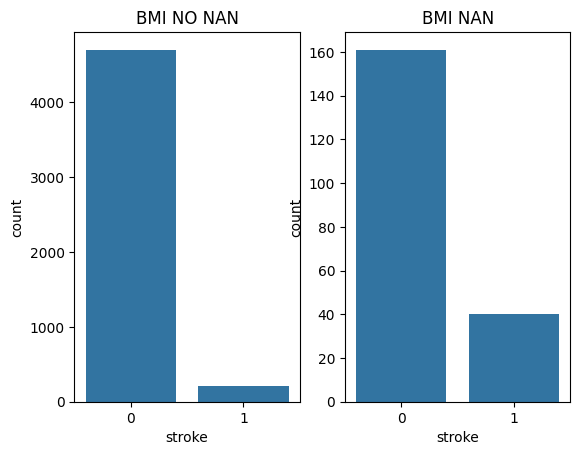

In [8]:
df_no_nan = df.dropna(axis="index", how="any")

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].set_title("BMI NO NAN")
sns.countplot(data=df_no_nan, x="stroke", ax=axs[0])
axs[1].set_title("BMI NAN")
sns.countplot(data=df[df.isnull().any(axis=1)], x="stroke", ax=axs[1])

Por el momento, se eliminan las filas con valores faltantes de bmi. Si en el modelo no se utiliza la variable bmi, es importante no eliminar los datos.

In [12]:
df.dropna(axis="index", how="any", inplace=True)

### Análisis de distribución de los datos
#### Variables categóricas

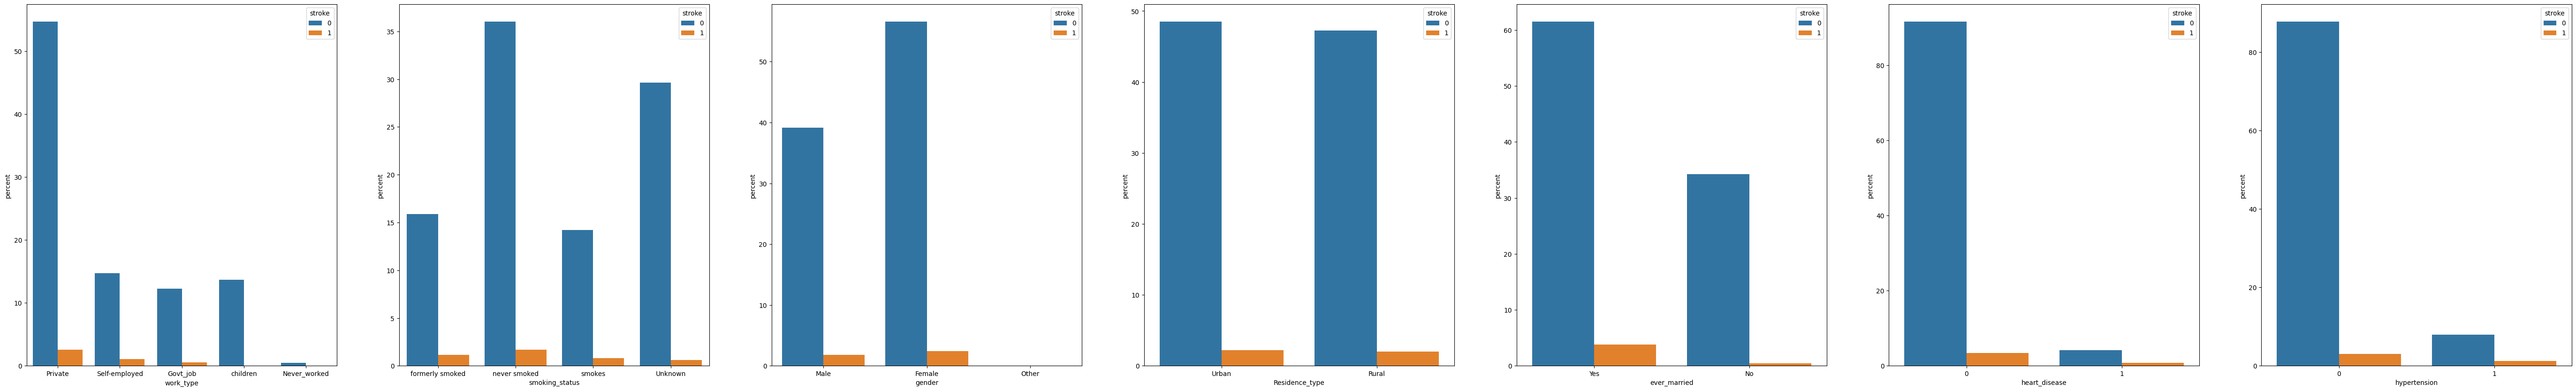

In [52]:
LABELS = [
    "work_type",
    "smoking_status",
    "gender",
    "Residence_type",
    "ever_married",
    "heart_disease",
    "hypertension",
]
fig, axs = plt.subplots(nrows=1, ncols=len(LABELS))
fig.set_size_inches(len(LABELS) * 10, 10)
for ax, label in zip(axs, LABELS):
    sns.countplot(df, x=label, hue="stroke", stat="percent", ax=ax)

#### Variables continuas

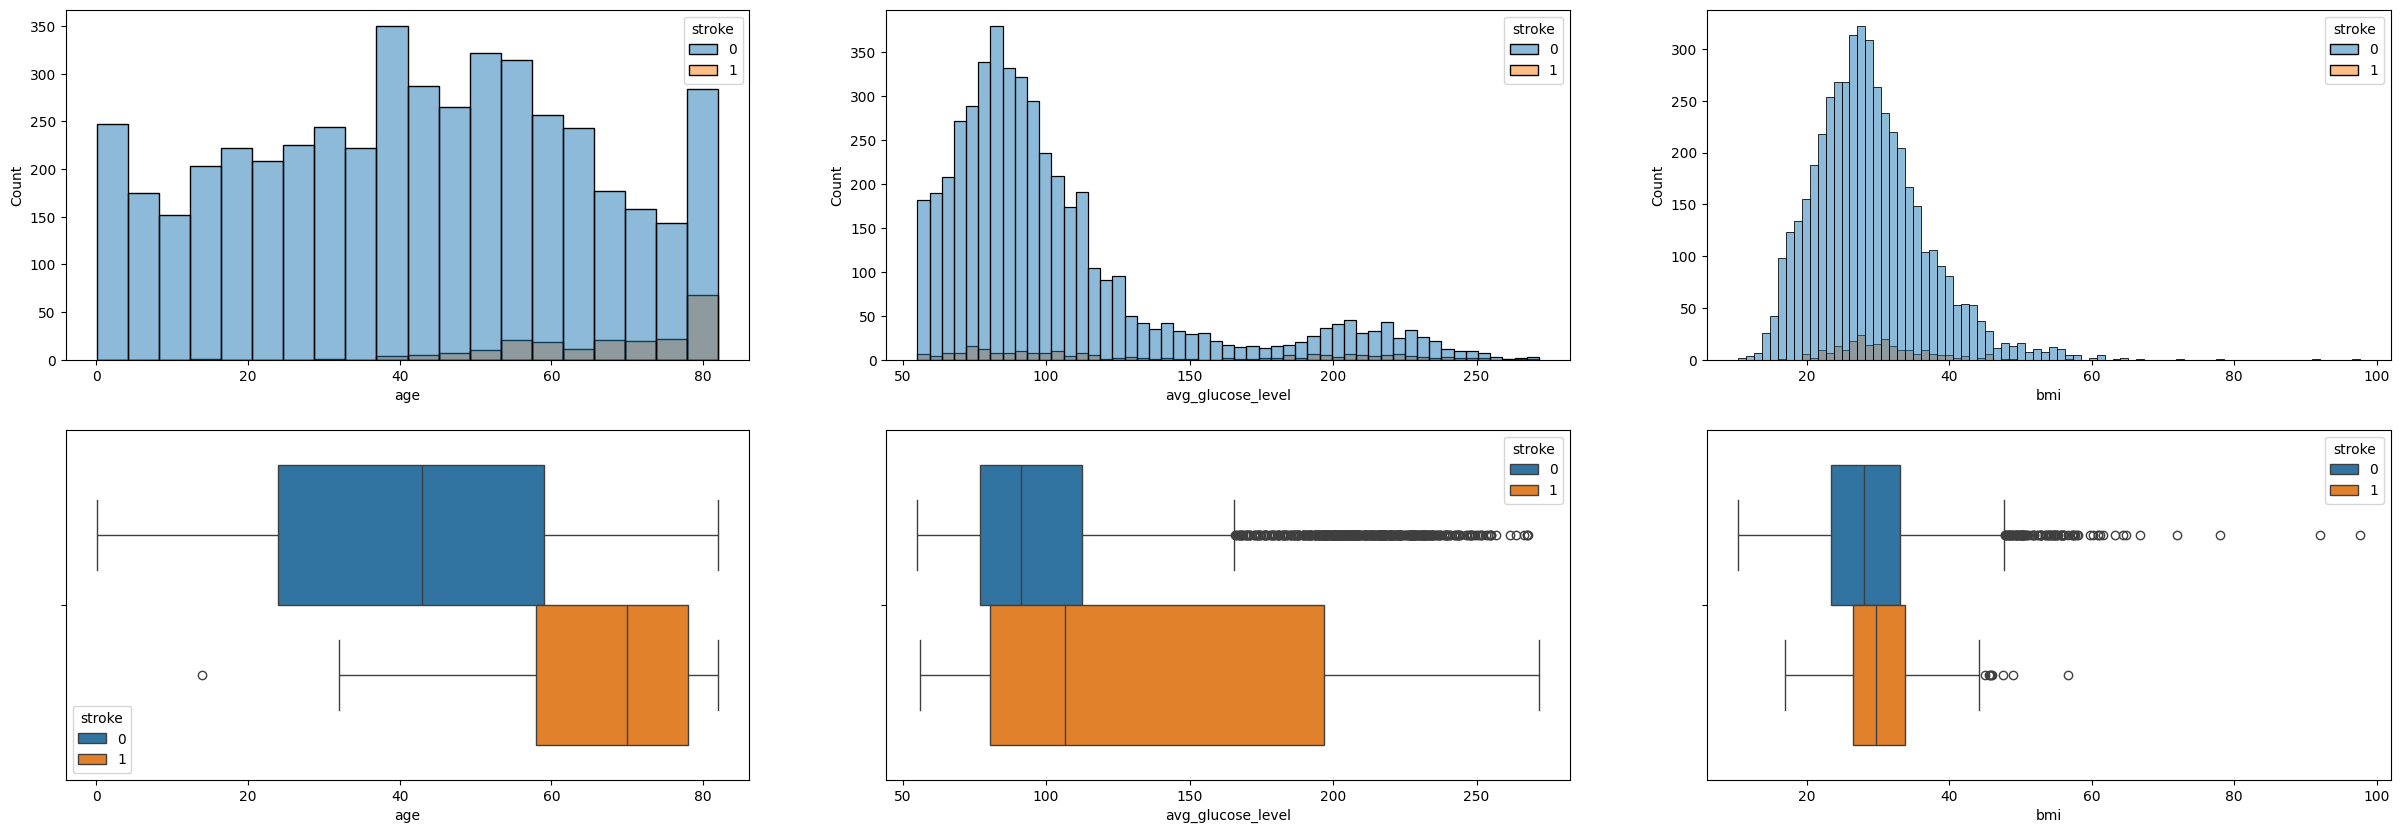

In [55]:
LABELS = ["age", "avg_glucose_level", "bmi"]
fig, axs = plt.subplots(nrows=2, ncols=len(LABELS))
fig.set_size_inches(len(LABELS) * 10, 10)
for ax_hist, ax_box, label in zip(axs[0], axs[1], LABELS):
    sns.histplot(df, x=label, hue="stroke", ax=ax_hist)
    sns.boxplot(df, x=label, hue="stroke", ax=ax_box)

- En la distribución de la edad se puede observar como hay una claro aumento en derrames cerebrales al aumentar la edad. Por el otro lado, el nivel de glucosa y indice de masa corporal paece tener la misma distribución para casos con y sin derrame cerebral.
- En la distribución del índice de masa corporal se observa una gran cantidad de outliers.

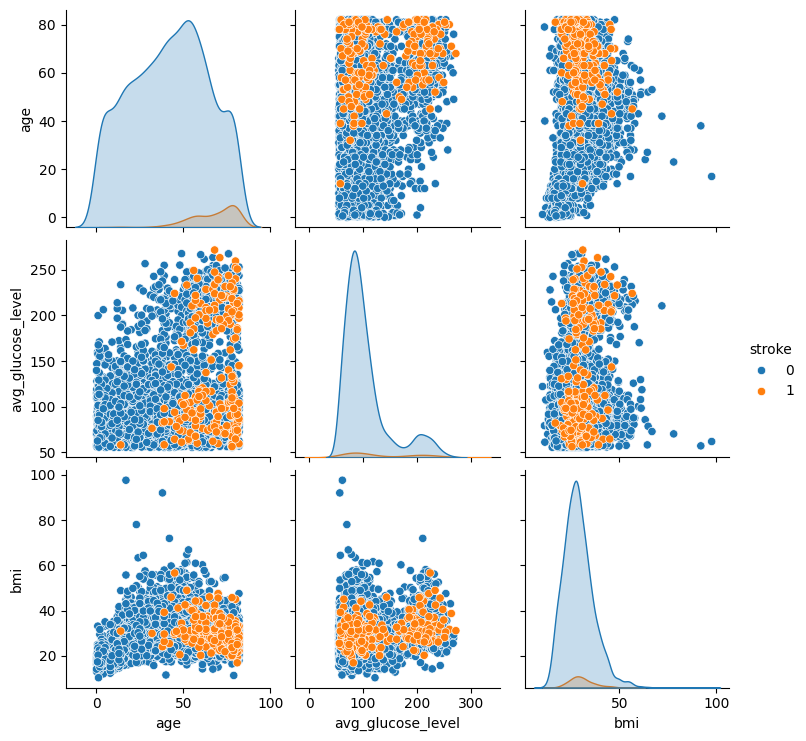

In [ ]:
sns.pairplot(
    df.drop(["hypertension", "heart_disease"], axis=1).sort_values("stroke"),
    hue="stroke",
)

### Análisis de correlación de las features

<Axes: title={'center': 'Map de calor con correlación de variables'}>

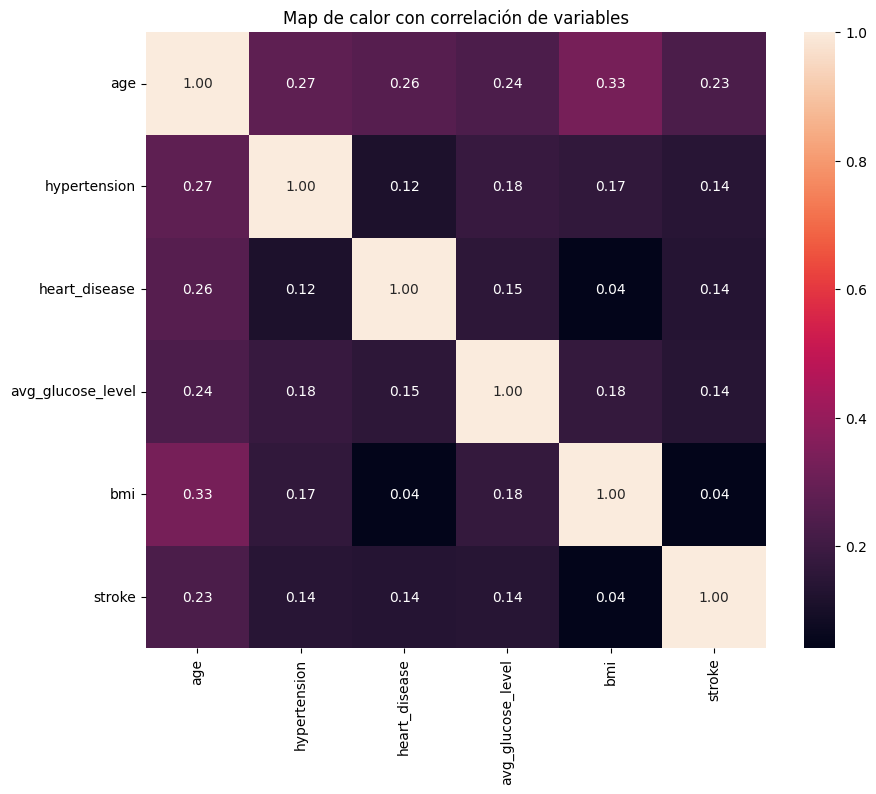

In [30]:
number = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
plt.title("Map de calor con correlación de variables")
sns.heatmap(number.corr(), annot=True, fmt=".2f")

Se puede observar una gran correlación entre:
- el índice de masa corporal y la presencia enfermedades cardíacas.
- el índice de masa corporal y la hipertensión.
- el índice de masa corporal y la presencia de derrame cerebral.
- la edad no parece tener una gran correlación con el resto de variables.

### Análisis de distribución de los datos

### Transformación de los datos
Transformación de variables categóricas. Posible mediante **One-Hot encoding** dada que la cantidad de categorías es relativamente baja y con poca probabilidad de cambiar/extenderse en el futuro.

In [64]:
# Cathegoric variables transformation
print("Applying One-Hot encoding to:")
for label, to_drop in [
    ("gender", "Other"),
    ("ever_married", "No"),
    ("work_type", "children"),
    ("Residence_type", "Rural"),
    ("smoking_status", "Unknown"),
]:
    unique_values = df[label].unique()
    print(label + ":", unique_values)
    prefix = "is" if len(unique_values) > 2 else label
    one_hot = pd.get_dummies(data=df[label], prefix=prefix).drop(
        prefix + "_" + to_drop if prefix else to_drop, axis=1
    )
    df.drop(label, axis=1, inplace=True)
    df = df.join(one_hot)
df.head()

Applying One-Hot encoding to:
gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,is_Female,is_Male,ever_married_Yes,is_Govt_job,is_Never_worked,is_Private,is_Self-employed,Residence_type_Urban,is_formerly smoked,is_never smoked,is_smokes
id,,,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.6,1,False,True,True,False,False,True,False,True,True,False,False
31112,80.0,0,1,105.92,32.5,1,False,True,True,False,False,True,False,False,False,True,False
60182,49.0,0,0,171.23,34.4,1,True,False,True,False,False,True,False,True,False,False,True
1665,79.0,1,0,174.12,24.0,1,True,False,True,False,False,False,True,False,False,True,False
56669,81.0,0,0,186.21,29.0,1,False,True,True,False,False,True,False,True,True,False,False


Gestión de clases imbalanceadas:

De [Datasets: Imbalanced datasets](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets), el grado de imbalance es **moderado**.

In [65]:
stroke_count = df.stroke.value_counts()
print(stroke_count, len(df))
print(f"Degree of imbalance: {stroke_count[1] / len(df) * 100:0.2f}%")

stroke
0    4700
1     209
Name: count, dtype: int64 4909
Degree of imbalance: 4.26%


### Entrenamiento de diferentes modelos ignorando desbalanceo
Separación del dataset en variable target y variables de entrada.

In [66]:
X = df.drop("stroke", axis=1).values
y = df["stroke"].values

Escalamiento de las variables de entrada. `RobustScaler` elimina la mediana y escala según el rango intercuartílico.

In [68]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

División en set de entrenamiento y de evaluación.

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

A continuación, los modelos a entrenar siguiendo el orden en que se estudiaron en la materia "Aprendizaje de Máquina I":

In [84]:
class StrokePredictionModel:
    """Machine learning model for stroke prediction"""

    def __init__(self, name: str, model: ClassifierMixin) -> None:
        self.name = name
        self.model = model
        self.accuracy = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1_score = 0.0
        self.confusion_matrix = None

In [85]:
predictors = [
    StrokePredictionModel(
        name="Regresión Logística", model=LogisticRegression(max_iter=1000)
    ),
    StrokePredictionModel(
        name="Clasificador KNN", model=KNeighborsClassifier(n_neighbors=3)
    ),
    StrokePredictionModel(
        name="Support Vector Machine", model=SVC(kernel="rbf", C=0.01, gamma=0.01)
    ),
    StrokePredictionModel(
        name="Árbol de decisión",
        model=DecisionTreeClassifier(criterion="log_loss", max_depth=50),
    ),
    StrokePredictionModel(name="Naive Bayes", model=GaussianNB()),
    StrokePredictionModel(
        name="Random Forest",
        model=RandomForestClassifier(
            n_estimators=20, criterion="log_loss", max_depth=50
        ),
    ),
]

Entrenamiento, validación y métricas de desempeño:

In [86]:
for predictor in predictors:
    predictor.model.fit(X_train, y_train)
    y_pred = predictor.model.predict(X_test)
    predictor.accuracy = accuracy_score(y_test, y_pred)
    predictor.precision = precision_score(y_test, y_pred)
    predictor.recall = recall_score(y_test, y_pred)
    predictor.f1_score = f1_score(y_test, y_pred)
    predictor.confusion_matrix = confusion_matrix(y_test, y_pred)

/home/ggf/workspace/ceia/ceia-amq1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ggf/workspace/ceia/ceia-amq1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Análisis de resultados:

In [88]:
pd.DataFrame.from_dict(
    {
        "name": [predictor.name for predictor in predictors],
        "accuracy": [predictor.accuracy for predictor in predictors],
        "precision": [predictor.precision for predictor in predictors],
        "recall": [predictor.recall for predictor in predictors],
        "f1_score": [predictor.f1_score for predictor in predictors],
    }
).sort_values("f1_score", ascending=False)

,name,accuracy,precision,recall,f1_score
3,Árbol de decisión,0.914460,0.207547,0.207547,0.207547
4,Naive Bayes,0.441955,0.084034,0.943396,0.154321
1,Clasificador KNN,0.939919,0.125000,0.018868,0.032787
0,Regresión Logística,0.946029,0.000000,0.000000,0.000000
2,Support Vector Machine,0.946029,0.000000,0.000000,0.000000
5,Random Forest,0.945010,0.000000,0.000000,0.000000


Todo el proceso puede resumirse en las siguientes funciones:

In [100]:
def stroke_prediction_analysis(X, y, scaler, predictors) -> tuple[pd.DataFrame, StrokePredictionModel]:
    # scale data
    X = scaler.fit_transform(X)
    # division in train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )
    for predictor in predictors:
        predictor.model.fit(X_train, y_train)
        y_pred = predictor.model.predict(X_test)
        predictor.accuracy = accuracy_score(y_test, y_pred)
        predictor.precision = precision_score(y_test, y_pred)
        predictor.recall = recall_score(y_test, y_pred)
        predictor.f1_score = f1_score(y_test, y_pred)
        predictor.confusion_matrix = confusion_matrix(y_test, y_pred)

    return pd.DataFrame.from_dict(
        {
            "name": [predictor.name for predictor in predictors],
            "accuracy": [predictor.accuracy for predictor in predictors],
            "precision": [predictor.precision for predictor in predictors],
            "recall": [predictor.recall for predictor in predictors],
            "f1_score": [predictor.f1_score for predictor in predictors],
        }
    ).sort_values("f1_score", ascending=False), sorted(predictors, key=lambda x: x.f1_score, reverse=True)[0]

### Entrenamiento desbalanceado de diferentes modelos
Se utiliza oversampling con [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Es una técnica que combate el problema de los conjuntos de datos desequilibrados, donde una clase (la clase minoritaria) tiene muchas menos muestras que la clase mayoritaria. En lugar de simplemente copiar las muestras existentes de la clase minoritaria, SMOTE genera nuevas muestras sintéticas. Lo hace creando puntos nuevos que están en el espacio entre los puntos existentes de la clase minoritaria, basándose en sus vecinos más cercanos.

In [93]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X, y)
print("Antes", X.shape, "despues", X_smote.shape)
print("Antes", y.shape, "despues", y_smote.shape)

Antes (4909, 16) despues (9400, 16)
Antes (4909,) despues (9400,)


In [102]:
df_results, best_predictor = stroke_prediction_analysis(X_smote, y_smote, scaler, predictors)
df_results

,name,accuracy,precision,recall,f1_score
0,Random Forest,0.975532,0.975992,0.975992,0.975992
1,Clasificador KNN,0.943085,0.907177,0.989562,0.946580
2,Árbol de decisión,0.933511,0.932503,0.937370,0.934930
3,Regresión Logística,0.780319,0.772228,0.806889,0.789178
4,Naive Bayes,0.703191,0.636799,0.971816,0.769421
5,Support Vector Machine,0.651064,0.721408,0.513570,0.600000


Matriz de confusión para el mejor modelo:

Text(0.5, 1.0, 'Matriz de confusión para Random Forest')

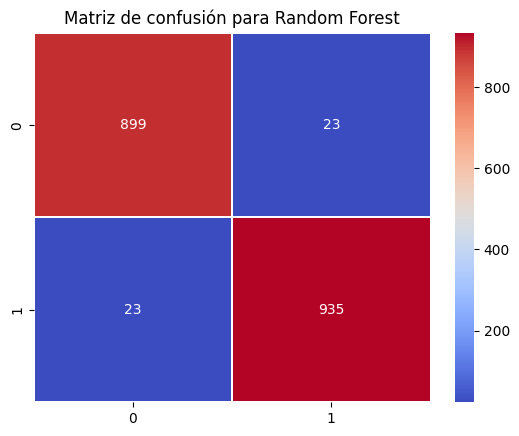

In [103]:
sns.heatmap(best_predictor.confusion_matrix, annot=True , cmap='coolwarm' , linewidths = 0.01 , fmt='g')
plt.title(f"Matriz de confusión para {best_predictor.name}")